# CMIP6 Access

### Objective
The objective of this notepad is to download and manipulate the ESM1 temperature data from the historic simulation from the CMIP6 data set.

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

#imports for pandas
import fsspec
import zarr

#imports for intake
import warnings 
warnings.filterwarnings("ignore")
import intake

## Data Access via Pandas
Accessing the data by use of the google API CMIP6 look up table with use of pandas.

### Loading data set table

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

### Searching data sets

In [4]:
dfFilt = df[df.variable_id.eq('thetao') & df.experiment_id.eq('historical') & df.source_id.eq('E3SM-1-0')]
print(str(len(dfFilt))+" datasets found.")

dfFilt2 = df[df.institution_id.eq('NCAR') & df.activity_id.eq('CMIP') 
             & df.table_id.eq('Amon') & df.variable_id.eq('tas') & df.experiment_id.eq('historical')]
dfFilt

5 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
270787,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190826
271418,CMIP,E3SM-Project,E3SM-1-0,historical,r2i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190830
401215,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
401216,CMIP,E3SM-Project,E3SM-1-0,historical,r3i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
430471,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200429


### Opening of data file

In [5]:
zstore = dfFilt.zstore.values[0]
mapper = fsspec.get_mapper(zstore)
fileRaw = xr.open_zarr(mapper, consolidated=True)
fileRaw

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lev: 60, lon: 360, time: 1980)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(60, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    thetao     (time, lev, lat, lon) float32 dask.array<chunksize=(12, 60, 180, 360), meta=np.ndarray>
Attributes: (12/56)
    Conventions:                    CF-1.7 CMIP-6.2
    activity_id:                    CMIP
    branch_method:                  standard
    branch_time_in_child:           0.0
    branch_time_in_parent:          36500.0
    cmor_version:                   3.4.0
    ...                             ...
    tracking_id:                    hdl:21.14100/f24a813c-25fc-4291-85ee-e3c3...
    variable_id:                    thetao
    variant_label:                  r1i1p1f1
    status:                         2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:            hdl:21.14100/f24a813c-25fc-4291-85ee-e3c3...
    version_id:                     v20190826

### Data display

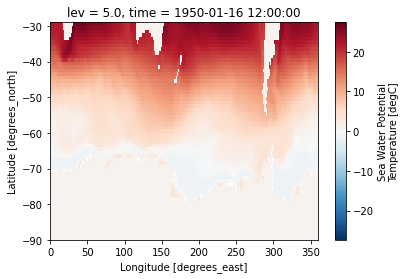

In [50]:
dataRaw = fileRaw.thetao #Modify to reflect variable ID
dataRelevant = dataRaw.sel(lat=slice(-89.5,-29.5)) #-89.5, -29.5
dataFilt15 = dataRelevant.sel(lev=5.0) #shows southern ocean only
#dataFilt15 = dataRaw.sel(lev=5.0) #shows full ocean projection
dataFilt15.sel(time='1950-01').squeeze().plot()

In [59]:
dataFilt15_1900 = dataFilt15.sel(time=slice('1900-01','1920-01'))
dataFilt15_1900.coords

Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5 -29.5
    lev      float64 5.0
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) object 1900-01-16 12:00:00 ... 1920-01-16 12:00:00

### Area weighting factor

In [54]:
dfArea = df[df.variable_id.eq('areacello') & df.source_id.eq('CESM2')]
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[0]), consolidated=True)
dataArea = dsArea.areacello
#dsArea #uncomment to show data properties

In [60]:
data4Graph = dataFilt15_1900 #Change to match selected dataset
totalArea = dataArea.sum(dim=['lon', 'lat'])
taTimeSeries = (data4Graph*dataArea).sum(dim=['lon', 'lat']) / totalArea
#taTimeSeries #uncomment to show data properties

<xarray.DataArray (time: 241)>
dask.array<truediv, shape=(241,), dtype=float64, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
    lev      float64 5.0
  * time     (time) object 1900-01-16 12:00:00 ... 1920-01-16 12:00:00

In [61]:
%time taTimeSeries.load() #run with caution, ensure number of calculations

Wall time: 30.7 s


<xarray.DataArray (time: 241)>
array([2.57706572, 2.76015932, 2.70117207, 2.45955557, 2.19640771,
       1.96289699, 1.80230385, 1.7083663 , 1.68245447, 1.74474452,
       1.91768501, 2.21745883, 2.5529427 , 2.72327277, 2.65708009,
       2.45881879, 2.21013864, 1.9780331 , 1.81143746, 1.71577753,
       1.6942212 , 1.74246434, 1.92386138, 2.2394327 , 2.58895675,
       2.75597966, 2.68235892, 2.45756489, 2.2025863 , 1.98225969,
       1.81932759, 1.72301803, 1.6985856 , 1.76272728, 1.95282683,
       2.2733049 , 2.64758233, 2.84116169, 2.73382574, 2.48280245,
       2.21827171, 1.99728961, 1.83032906, 1.73262964, 1.70551512,
       1.76470335, 1.93571453, 2.26013983, 2.64400622, 2.81002977,
       2.72981415, 2.48697157, 2.21600668, 1.97818516, 1.81587488,
       1.72187439, 1.69611607, 1.7517475 , 1.929881  , 2.2442358 ,
       2.62756791, 2.80792603, 2.73638764, 2.48726   , 2.20903733,
       1.9690663 , 1.80486864, 1.70773757, 1.68011223, 1.74838807,
       1.92918744, 2.26184421, 2.66955472, 2.86587606, 2.75874597,
       2.50023685, 2.2149296 , 1.96991746, 1.81116739, 1.72033954,
       1.70163309, 1.75928977, 1.94565005, 2.24857101, 2.60370583,
       2.76537384, 2.71941818, 2.48816944, 2.21404053, 1.97137495,
       1.80926762, 1.72114906, 1.69559822, 1.76837146, 1.94386366,
       2.25612835, 2.60789623, 2.78887948, 2.71445423, 2.46704391,
...
       2.75358676, 2.68786036, 2.46976106, 2.22429548, 1.99854214,
       1.83340147, 1.73386484, 1.71014673, 1.76449034, 1.93867037,
       2.24486025, 2.59428669, 2.76134036, 2.69646758, 2.47327512,
       2.20689512, 1.98793304, 1.82245239, 1.73106752, 1.71108018,
       1.75932542, 1.92260096, 2.25679635, 2.61621117, 2.78703717,
       2.71850052, 2.48145443, 2.20693416, 1.97591949, 1.81811294,
       1.72521199, 1.69498833, 1.74409834, 1.91018358, 2.22785432,
       2.59076463, 2.76087211, 2.69080769, 2.46360006, 2.1964032 ,
       1.969737  , 1.81123949, 1.72281203, 1.69788353, 1.74537816,
       1.92449199, 2.24442729, 2.64503171, 2.82773829, 2.7257115 ,
       2.48561743, 2.20442764, 1.9691697 , 1.81035801, 1.71512258,
       1.68942192, 1.75173136, 1.94175734, 2.2922446 , 2.66018975,
       2.8356605 , 2.73861035, 2.49082941, 2.21801671, 1.9876254 ,
       1.82413569, 1.72841296, 1.70090082, 1.75528796, 1.91703539,
       2.2294109 , 2.55898186, 2.73251105, 2.66718003, 2.45146241,
       2.19831438, 1.98082566, 1.82421005, 1.72522792, 1.70077025,
       1.74258488, 1.91638675, 2.23056974, 2.56418906, 2.73578479,
       2.68111706, 2.46585305, 2.20712274, 1.98413089, 1.8243757 ,
       1.73547052, 1.71284196, 1.77493736, 1.95770836, 2.27682678,
       2.62493384])
Coordinates:
    lev      float64 5.0
  * time     (time) object 1900-01-16 12:00:00 ... 1920-01-16 12:00:00

Text(0.5, 1.0, 'Southern Ocean Mean Temperature at lev 5')

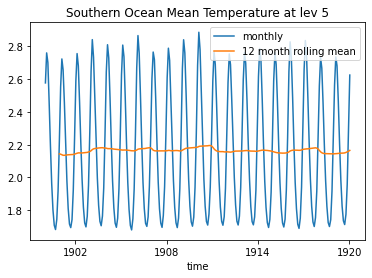

In [62]:
taTimeSeries.plot(label='monthly')
taTimeSeries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Southern Ocean Mean Temperature at lev 5')

## Data Access via intake
The project data can also be accessed using the intake feature.

### Opening datastore

In [64]:
url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

,unique
activity_id,17
institution_id,36
source_id,86
experiment_id,168
member_id,650
table_id,37
variable_id,709
grid_label,10
zstore,502742
dcpp_init_year,60


In [65]:
query = dict(
    experiment_id=['abrupt-4xCO2', 'piControl'],
    table_id='Amon',
    variable_id=['tas','rsut','rsdt','rlut'],
    member_id='r1i1p1f1'
)

colSubset = col.search(require_all_on=["source_id"], **query)
colSubset.df.groupby("source_id")[
    ["experiment_id","variable_id","table_id"]
].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,2,4,1
ACCESS-ESM1-5,2,4,1
AWI-CM-1-1-MR,2,4,1
BCC-CSM2-MR,2,4,1
BCC-ESM1,2,4,1
CAMS-CSM1-0,2,4,1
CAS-ESM2-0,2,4,1
CESM2,2,4,1
CESM2-FV2,2,4,1


In [66]:
def drop_all_bounds(ds):
    dropVars = [vname for vname in ds.coords
               if (('_bounds') in vname) or ('_bnds') in vname]
    return ds.drop(dropVars)

def open_dsets(df):
    dsets = [xr.open_zarr(fsspec.get_mapper(dsUrl), consolidated=True)
             .pipe(drop_all_bounds)
             for dsUrl in df.zstore]
    try:
        ds = xr.merge(dsets, join='exact')
        return ds
    except ValueError:
        return None
    
def open_delayed(df):
    return dask.delayed(open_dsets)(df)

### Nested dictionary of model and experiments

In [67]:
from collections import defaultdict

dsets = defaultdict(dict)
for group, df in colSubset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_dsets(df) #should be open_delayed

### Directly opening a single dataset

In [68]:
%time open_dsets(df)

Wall time: 6.81 s


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 6000)
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0201-01-16 12:00:00 ... 0700-12-16 12:00:00
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(407, 192, 288), meta=np.ndarray>
    rsdt     (time, lat, lon) float32 dask.array<chunksize=(498, 192, 288), meta=np.ndarray>
    rsut     (time, lat, lon) float32 dask.array<chunksize=(328, 192, 288), meta=np.ndarray>
    rlut     (time, lat, lon) float32 dask.array<chunksize=(355, 192, 288), meta=np.ndarray>
Attributes: (12/53)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             branch-restart from year 0201-01-01 of piContr...
    branch_time:               0.0
    branch_time_in_child:      430335.0
    branch_time_in_parent:     430335.0
    ...                        ...
    title:                     TaiESM1 output prepared for CMIP6
    tracking_id:               hdl:21.14100/d88ca002-03c3-4fde-add4-0cac448ca...
    variable_id:               tas
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/d88ca002-03c3-4fde-add4-0cac448ca...
    version_id:                v20200211